In [137]:
import pandas as pd

In [138]:
df = pd.read_csv('filtered3_df_full.csv')

In [139]:
df.columns.values

array(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Season',
       'Game_ID', 'PLAYER_NAME', 'Team', 'GAME_DATE', 'MATCHUP', 'WL',
       'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM',
       'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV',
       'PF', 'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE', 'DD', 'TD',
       'total_fantasy_points', 'salary', 'POS'], dtype=object)

In [140]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [141]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# model 1

In [142]:
df = df[['PLAYER_NAME', 'POS', 'Team', 'GAME_DATE', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT',
       'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK',
       'TOV', 'PF', 'PTS', 'PLUS_MINUS',
       'total_fantasy_points']]

# encode player positions
le = LabelEncoder()
df["POS"] = le.fit_transform(df["POS"])
df["Team"]= le.fit_transform(df["Team"])

# scale numerical features
numerical_features = ['MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT',
                      'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK',
                      'TOV', 'PF', 'PTS', 'PLUS_MINUS']
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# sequences of games for each player
sequence_length = 50  # Set the number of past games to consider for each player
input_features = len(numerical_features) + 1  # Number of input features + position encoding
X = []
y = []

for player_name in df['PLAYER_NAME'].unique():
    player_data = df[df['PLAYER_NAME'] == player_name].reset_index(drop=True)
    if len(player_data) >= sequence_length:  # Check if the player has at least 50 games
        for i in range(len(player_data) - sequence_length):
            X.append(player_data.loc[i:i + sequence_length - 1, numerical_features + ['POS']].values)
            y.append(player_data.loc[i + sequence_length, 'total_fantasy_points'])

X = np.array(X)
y = np.array(y)


# train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [143]:
def regression_accuracy(y_true, y_pred, threshold=0.3):
    assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"
    within_threshold = torch.abs(y_true - y_pred) <= (threshold * y_true)
    accuracy = torch.mean(within_threshold.type(torch.float32))
    return accuracy.item()

In [144]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

# parameters
hidden_size = 128
num_layers = 3
output_size = 1
dropout_prob = 0.5

# model, loss function, optimizer
model = LSTMModel(input_features, hidden_size, num_layers, output_size, dropout_prob)
criterion = nn.L1Loss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, 
                                                       verbose=True)

# training loop
num_epochs = 100
batch_size = 8
train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# store values
train_losses = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    epoch_loss = 0
    n_batches = 0
    for i in range(0, len(train_tensor), batch_size):
        batch_X = train_tensor[i:i + batch_size]
        batch_y = y_train_tensor[i:i + batch_size]

        # forward
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        epoch_loss += loss.item()
        n_batches += 1

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # average loss for epoch
    avg_epoch_loss = epoch_loss / n_batches
    print(f'Epoch [{epoch + 1}/{num_epochs}], Average Loss: {avg_epoch_loss:.4f}')

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor)
        test_loss = criterion(y_pred, y_test_tensor)
        test_accuracy = regression_accuracy(y_test_tensor, y_pred)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Average Test Loss: {test_loss.item():.4f}, Test Accuracy: {test_accuracy:.4f}')
        
        # Update the learning rate
        scheduler.step(test_loss)
    
    # Append the loss and accuracy values to the corresponding lists
    train_losses.append(avg_epoch_loss)
    test_losses.append(test_loss.item())
    test_accuracies.append(test_accuracy)
    
    # train
    model.train()


Epoch [1/100], Average Loss: 10.6234
Epoch [1/100], Average Test Loss: 8.6542, Test Accuracy: 0.4714
Epoch [2/100], Average Loss: 8.5108
Epoch [2/100], Average Test Loss: 8.6544, Test Accuracy: 0.4714
Epoch [3/100], Average Loss: 8.4440
Epoch [3/100], Average Test Loss: 8.6542, Test Accuracy: 0.4714
Epoch [4/100], Average Loss: 8.5158
Epoch [4/100], Average Test Loss: 8.6553, Test Accuracy: 0.4753
Epoch [5/100], Average Loss: 8.5098
Epoch [5/100], Average Test Loss: 8.6538, Test Accuracy: 0.4714
Epoch [6/100], Average Loss: 8.5244
Epoch [6/100], Average Test Loss: 8.6540, Test Accuracy: 0.4714
Epoch [7/100], Average Loss: 8.4887
Epoch [7/100], Average Test Loss: 8.6547, Test Accuracy: 0.4714
Epoch 00007: reducing learning rate of group 0 to 5.0000e-04.
Epoch [8/100], Average Loss: 8.4460
Epoch [8/100], Average Test Loss: 8.6554, Test Accuracy: 0.4753
Epoch [9/100], Average Loss: 8.5772
Epoch [9/100], Average Test Loss: 8.6524, Test Accuracy: 0.4813
Epoch [10/100], Average Loss: 8.1036


Epoch [79/100], Average Loss: 3.2900
Epoch [79/100], Average Test Loss: 3.4482, Test Accuracy: 0.8284
Epoch [80/100], Average Loss: 3.4045
Epoch [80/100], Average Test Loss: 3.4732, Test Accuracy: 0.8264
Epoch [81/100], Average Loss: 3.4634
Epoch [81/100], Average Test Loss: 3.4860, Test Accuracy: 0.8284
Epoch [82/100], Average Loss: 3.3866
Epoch [82/100], Average Test Loss: 3.4774, Test Accuracy: 0.8323
Epoch [83/100], Average Loss: 3.4392
Epoch [83/100], Average Test Loss: 3.4971, Test Accuracy: 0.8264
Epoch 00083: reducing learning rate of group 0 to 1.5625e-05.
Epoch [84/100], Average Loss: 3.3303
Epoch [84/100], Average Test Loss: 3.4817, Test Accuracy: 0.8264
Epoch [85/100], Average Loss: 3.4302
Epoch [85/100], Average Test Loss: 3.4973, Test Accuracy: 0.8284
Epoch [86/100], Average Loss: 3.3537
Epoch [86/100], Average Test Loss: 3.4900, Test Accuracy: 0.8264
Epoch [87/100], Average Loss: 3.4725
Epoch [87/100], Average Test Loss: 3.4817, Test Accuracy: 0.8264
Epoch [88/100], Aver

In [145]:
from sklearn.metrics import mean_absolute_error, r2_score

y_pred_np = y_pred.numpy().flatten()
y_test_np = y_test_tensor.numpy().flatten()

mae = mean_absolute_error(y_test_np, y_pred_np)
r2 = r2_score(y_test_np, y_pred_np)

print(f'Mean Absolute Error: {mae:.4f}')
print(f'R^2 Score: {r2:.4f}')

Mean Absolute Error: 3.4706
R^2 Score: 0.7290


In [147]:
import matplotlib.pyplot as plt

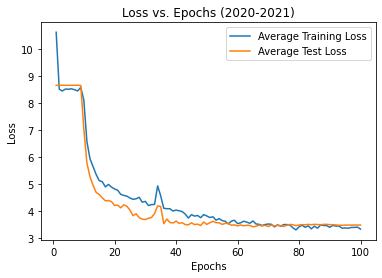

In [150]:
# Plot training and testing losses
plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses, label='Average Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Average Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs (2020-2021)')
plt.legend()
plt.show()

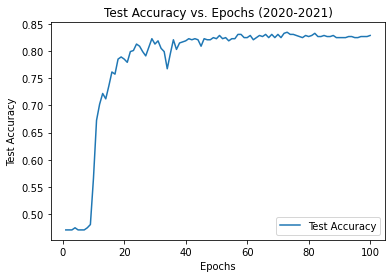

In [151]:
# Plot testing accuracy
plt.figure()
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Epochs (2020-2021)')
plt.legend()
plt.show()

# model 2

In [ ]:
df = df[['PLAYER_NAME', 'POS', 'Team', 'GAME_DATE', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT',
       'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK',
       'TOV', 'PF', 'PTS', 'PLUS_MINUS',
       'total_fantasy_points']]

# encode player positions
le = LabelEncoder()
df["POS"] = le.fit_transform(df["POS"])
df["Team"]= le.fit_transform(df["Team"])

# scale numerical features
numerical_features = ['MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT',
                      'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK',
                      'TOV', 'PF', 'PTS', 'PLUS_MINUS']
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# sequences of games for each player
sequence_length = 50  # Set the number of past games to consider for each player
input_features = len(numerical_features) + 1  # Number of input features + position encoding
X = []
y = []

for player_name in df['PLAYER_NAME'].unique():
    player_data = df[df['PLAYER_NAME'] == player_name].reset_index(drop=True)
    if len(player_data) >= sequence_length:  # Check if the player has at least 50 games
        for i in range(len(player_data) - sequence_length):
            X.append(player_data.loc[i:i + sequence_length - 1, numerical_features + ['POS']].values)
            y.append(player_data.loc[i + sequence_length, 'total_fantasy_points'])

X = np.array(X)
y = np.array(y)


# train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
# LSTM model 
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

# parameters
hidden_size = 64
num_layers = 2
output_size = 1

# model, loss function, optimizer
model = LSTMModel(input_features, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [8]:
def regression_accuracy(y_true, y_pred, threshold=0.3):
    assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"
    within_threshold = torch.abs(y_true - y_pred) <= (threshold * y_true)
    accuracy = torch.mean(within_threshold.type(torch.float32))
    return accuracy.item()

In [9]:
num_epochs = 100
batch_size = 8
train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

for epoch in range(num_epochs):
    epoch_loss = 0
    n_batches = 0
    for i in range(0, len(train_tensor), batch_size):
        batch_X = train_tensor[i:i + batch_size]
        batch_y = y_train_tensor[i:i + batch_size]

        # forward
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        epoch_loss += loss.item()
        n_batches += 1

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # average loss for epoch
    avg_epoch_loss = epoch_loss / n_batches
    print(f'Epoch [{epoch + 1}/{num_epochs}], Average Loss: {avg_epoch_loss:.4f}')

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor)
        test_loss = criterion(y_pred, y_test_tensor)
        test_accuracy = regression_accuracy(y_test_tensor, y_pred)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Average Test Loss: {test_loss.item():.4f}, Test Accuracy: {test_accuracy:.4f}')
    # train
    model.train()


Epoch [1/100], Average Loss: 280.5465
Epoch [1/100], Average Test Loss: 157.4014, Test Accuracy: 0.4556
Epoch [2/100], Average Loss: 129.8602
Epoch [2/100], Average Test Loss: 129.5764, Test Accuracy: 0.4556
Epoch [3/100], Average Loss: 122.3947
Epoch [3/100], Average Test Loss: 128.8477, Test Accuracy: 0.4458
Epoch [4/100], Average Loss: 122.3301
Epoch [4/100], Average Test Loss: 128.7806, Test Accuracy: 0.4458
Epoch [5/100], Average Loss: 102.4673
Epoch [5/100], Average Test Loss: 77.0845, Test Accuracy: 0.6844
Epoch [6/100], Average Loss: 64.2551
Epoch [6/100], Average Test Loss: 59.9792, Test Accuracy: 0.7140
Epoch [7/100], Average Loss: 52.9698
Epoch [7/100], Average Test Loss: 53.8908, Test Accuracy: 0.7278
Epoch [8/100], Average Loss: 46.3377
Epoch [8/100], Average Test Loss: 49.3219, Test Accuracy: 0.7535
Epoch [9/100], Average Loss: 42.6789
Epoch [9/100], Average Test Loss: 46.9387, Test Accuracy: 0.7594
Epoch [10/100], Average Loss: 39.0522
Epoch [10/100], Average Test Loss: 

Epoch [81/100], Average Loss: 1.6583
Epoch [81/100], Average Test Loss: 50.5410, Test Accuracy: 0.7456
Epoch [82/100], Average Loss: 1.7533
Epoch [82/100], Average Test Loss: 49.1530, Test Accuracy: 0.7495
Epoch [83/100], Average Loss: 2.2276
Epoch [83/100], Average Test Loss: 52.2982, Test Accuracy: 0.7061
Epoch [84/100], Average Loss: 1.8846
Epoch [84/100], Average Test Loss: 48.1783, Test Accuracy: 0.7495
Epoch [85/100], Average Loss: 1.5289
Epoch [85/100], Average Test Loss: 50.6996, Test Accuracy: 0.7258
Epoch [86/100], Average Loss: 1.3653
Epoch [86/100], Average Test Loss: 50.7758, Test Accuracy: 0.7318
Epoch [87/100], Average Loss: 1.2027
Epoch [87/100], Average Test Loss: 50.3698, Test Accuracy: 0.7298
Epoch [88/100], Average Loss: 1.1608
Epoch [88/100], Average Test Loss: 50.3150, Test Accuracy: 0.7199
Epoch [89/100], Average Loss: 1.1875
Epoch [89/100], Average Test Loss: 48.9649, Test Accuracy: 0.7337
Epoch [90/100], Average Loss: 1.2829
Epoch [90/100], Average Test Loss: 4

In [10]:
from sklearn.metrics import mean_absolute_error, r2_score

y_pred_np = y_pred.numpy().flatten()
y_test_np = y_test_tensor.numpy().flatten()

mae = mean_absolute_error(y_test_np, y_pred_np)
r2 = r2_score(y_test_np, y_pred_np)

print(f'Mean Absolute Error: {mae:.4f}')
print(f'R^2 Score: {r2:.4f}')

Mean Absolute Error: 4.5834
R^2 Score: 0.6585


## Now that we have trained the LSTM model, let us construct a function that predicts the total fantasy points that each player will generate for their next future game. 

In [152]:
sequence_length = 50

player_names_50 = []
for player_name in df['PLAYER_NAME'].unique():
    player_data = df[df['PLAYER_NAME'] == player_name].reset_index(drop=True)
    if len(player_data) >= sequence_length:
        player_names_50.append(player_name)

player_names_50 

['Alex Len',
 'Bam Adebayo',
 'Bismack Biyombo',
 'Brook Lopez',
 'Bruno Fernando',
 'Cameron Payne',
 'Chris Paul',
 'Clint Capela',
 'Damian Jones',
 'Damian Lillard',
 'Daniel Gafford',
 'Darius Bazley',
 'Darius Garland',
 "De'Aaron Fox",
 'DeAndre Jordan',
 'Deandre Ayton',
 'Dejounte Murray',
 'Devin Booker',
 "Devonte' Graham",
 'Drew Eubanks',
 'Dwight Powell',
 'Frank Kaminsky',
 'Isaiah Stewart',
 'Ivica Zubac',
 'Ja Morant',
 'Jakob Poeltl',
 'Jalen McDaniels',
 'James Wiseman',
 'Jarrett Allen',
 'Jaxson Hayes',
 'Jordan McLaughlin',
 'Josh Hart',
 'Justin Holiday',
 'Karl-Anthony Towns',
 'Kawhi Leonard',
 'Kendrick Nunn',
 'Kevin Durant',
 'Kevon Looney',
 'Kyrie Irving',
 'LaMelo Ball',
 'Landry Shamet',
 'Mason Plumlee',
 'Matisse Thybulle',
 'Mikal Bridges',
 'Mike Conley',
 'Mike Muscala',
 'Moses Brown',
 'Nerlens Noel',
 'Pat Connaughton',
 'Patrick Beverley',
 'Paul George',
 'Payton Pritchard',
 'Reggie Jackson',
 'Ricky Rubio',
 'Robin Lopez',
 'Rudy Gobert',
 'R

In [153]:
seq_lengths = []
for player_name in df['PLAYER_NAME'].unique():
    player_data = df[df['PLAYER_NAME'] == player_name]
    seq_lengths.append({'PLAYER_NAME': player_name, 'SEQ_LENGTH': len(player_data)})
seq_lengths_df = pd.DataFrame(seq_lengths)
seq_lengths_df

,PLAYER_NAME,SEQ_LENGTH
0,Aaron Gordon,12
1,Alec Burks,35
2,Aleksej Pokusevski,31
3,Alex Len,63
4,Amir Coffey,25
...,...,...
255,Trent Forrest,28
256,Troy Brown Jr.,16
257,Ty Jerome,9
258,Udonis Haslem,1


In [154]:
filtered_df = seq_lengths_df[seq_lengths_df['SEQ_LENGTH'] >= 50]
print(filtered_df)

         PLAYER_NAME  SEQ_LENGTH
3           Alex Len          63
8        Bam Adebayo          63
9    Bismack Biyombo          64
12       Brook Lopez          66
14    Bruno Fernando          93
..               ...         ...
241       Obi Toppin          59
247       RJ Barrett          52
250        Saben Lee         144
251       Saddiq Bey          54
259      Will Barton          51

[82 rows x 2 columns]


In [155]:
player_name = 'Alex Len'
player_points_sequence = df.loc[df['PLAYER_NAME'] == player_name, 'total_fantasy_points'].tolist()
player_points_sequence

[14.75,
 13.5,
 13.75,
 22.0,
 33.25,
 22.75,
 11.0,
 8.0,
 10.25,
 24.0,
 5.0,
 20.0,
 11.75,
 5.75,
 20.75,
 11.0,
 20.5,
 5.75,
 5.5,
 8.5,
 21.75,
 17.0,
 20.75,
 24.25,
 7.25,
 4.5,
 8.0,
 10.25,
 9.0,
 28.25,
 5.75,
 15.75,
 28.0,
 15.25,
 26.5,
 15.0,
 10.5,
 13.0,
 7.25,
 28.75,
 15.5,
 28.0,
 17.75,
 8.0,
 16.75,
 18.25,
 11.75,
 16.75,
 23.25,
 10.0,
 9.75,
 14.0,
 7.0,
 18.75,
 19.5,
 15.25,
 10.75,
 10.5,
 29.0,
 27.0,
 17.75,
 19.75,
 15.75]

## example of one player's predicted total fantasy points for their next game

In [156]:
# MODEL 1
# drop na values
seq_lengths_df = seq_lengths_df[(seq_lengths_df != 0).all(1)].dropna()

# most recent sequence of games
player_name = 'Alex Len'
player_data = df[df['PLAYER_NAME'] == player_name].reset_index(drop=True)

# player max sequence length from seq_lengths_df
sequence_length = seq_lengths_df.loc[seq_lengths_df['PLAYER_NAME'] == player_name, 'SEQ_LENGTH'].item()
last_sequence = player_data.iloc[-sequence_length:, :]

# numerical features scaled
last_sequence[numerical_features] = scaler.transform(last_sequence[numerical_features])

# convert to tensor and predict future total fantasy points for next game
with torch.no_grad():
    input_tensor = torch.tensor(last_sequence[numerical_features + ['POS']].values.reshape(1, -1, input_features),
                                dtype=torch.float32)
    pred = model(input_tensor).item()
    print(f'Predicted total fantasy points for {player_name} in the next game: {pred:.2f}')


Predicted total fantasy points for Alex Len in the next game: 6.47


In [14]:
# MODEL 2
# drop na values
seq_lengths_df = seq_lengths_df[(seq_lengths_df != 0).all(1)].dropna()

# most recent sequence of games
player_name = 'Alex Len'
player_data = df[df['PLAYER_NAME'] == player_name].reset_index(drop=True)

# player max sequence length from seq_lengths_df
sequence_length = seq_lengths_df.loc[seq_lengths_df['PLAYER_NAME'] == player_name, 'SEQ_LENGTH'].item()
last_sequence = player_data.iloc[-sequence_length:, :]

# numerical features scaled
last_sequence[numerical_features] = scaler.transform(last_sequence[numerical_features])

# convert to tensor and predict future total fantasy points for next game
with torch.no_grad():
    input_tensor = torch.tensor(last_sequence[numerical_features + ['POS']].values.reshape(1, -1, input_features),
                                dtype=torch.float32)
    pred = model(input_tensor).item()
    print(f'Predicted total fantasy points for {player_name} in the next game: {pred:.2f}')


Predicted total fantasy points for Alex Len in the next game: 5.08


# sequence length for all games

In [157]:
seq_lengths = []
for player_name in df['PLAYER_NAME'].unique():
    player_data = df[df['PLAYER_NAME'] == player_name]
    seq_lengths.append({'PLAYER_NAME': player_name, 'SEQ_LENGTH': len(player_data)})
seq_lengths_df = pd.DataFrame(seq_lengths)
seq_lengths_df
seq_lengths_df = seq_lengths_df[(seq_lengths_df != 0).all(1)].dropna()

In [158]:
seq_lengths_df

,PLAYER_NAME,SEQ_LENGTH
0,Aaron Gordon,12
1,Alec Burks,35
2,Aleksej Pokusevski,31
3,Alex Len,63
4,Amir Coffey,25
...,...,...
255,Trent Forrest,28
256,Troy Brown Jr.,16
257,Ty Jerome,9
258,Udonis Haslem,1


# sequence length with cutoff date

In [159]:
seq_lengths = []
cutoff_date = '2021-01-16'  # Specify the cutoff date as a string in the format 'YYYY-MM-DD'

for player_name in df['PLAYER_NAME'].unique():
    player_data = df[(df['PLAYER_NAME'] == player_name) & (df['GAME_DATE'] < cutoff_date)]
    seq_lengths.append({'PLAYER_NAME': player_name, 'SEQ_LENGTH': len(player_data)})
    
seq_lengths_cut_df = pd.DataFrame(seq_lengths)
seq_lengths_cut_df = seq_lengths_cut_df[(seq_lengths_cut_df != 0).all(1)].dropna()
seq_lengths_cut_df.drop_duplicates(subset=['PLAYER_NAME'], keep='first', inplace=True)


In [160]:
seq_lengths_cut_df

,PLAYER_NAME,SEQ_LENGTH
0,Aaron Gordon,11
1,Alec Burks,3
2,Aleksej Pokusevski,10
3,Alex Len,7
4,Amir Coffey,8
...,...,...
245,Paul Reed,3
248,Rodney McGruder,1
249,Rudy Gay,2
250,Saben Lee,6


## function that predicts all players total fantasy points for their next game

In [161]:
# FOR MODEL 1
def predict_next_game_scores(df, seq_lengths_df, numerical_features, input_features, scaler, model, unique_players):
    player_names = []
    predicted_scores = []
    
    for player_name in unique_players:
        player_data = df[df['PLAYER_NAME'] == player_name].reset_index(drop=True)
        
        if not player_data.empty:
            sequence_length = seq_lengths_df.loc[seq_lengths_df['PLAYER_NAME'] == player_name, 'SEQ_LENGTH'].item()
            last_sequence = player_data.iloc[-sequence_length:, :]
            last_sequence[numerical_features] = scaler.transform(last_sequence[numerical_features])
            
            
            with torch.no_grad():
                input_tensor = torch.tensor(last_sequence[numerical_features + ['POS']].values.reshape(1, -1, input_features),
                                            dtype=torch.float32)
                pred = model(input_tensor).item()
                
            player_names.append(player_name)
            predicted_scores.append(pred)
        else:
            player_names.append(player_name)
            predicted_scores.append(None)

    predictions_df = pd.DataFrame({'PLAYER_NAME': player_names, 'PRED_SCORE': predicted_scores})
    predictions_df = predictions_df.dropna()
    return predictions_df


unique_players = df['PLAYER_NAME'].unique()


player_predictions_df_1 = predict_next_game_scores(df, seq_lengths_df, numerical_features, input_features, scaler, model, unique_players)


print(player_predictions_df_1)


            PLAYER_NAME  PRED_SCORE
0          Aaron Gordon    6.654842
1            Alec Burks    4.490297
2    Aleksej Pokusevski    4.334994
3              Alex Len    6.708607
4           Amir Coffey    7.057501
..                  ...         ...
255       Trent Forrest    3.854125
256      Troy Brown Jr.    3.852165
257           Ty Jerome    5.649981
258       Udonis Haslem    2.987902
259         Will Barton    5.752344

[260 rows x 2 columns]


In [116]:
# FOR MODEL 2

def predict_next_game_scores(df, seq_lengths_df, numerical_features, input_features, scaler, model, unique_players):
    player_names = []
    predicted_scores = []
    
    for player_name in unique_players:
        player_data = df[df['PLAYER_NAME'] == player_name].reset_index(drop=True)
        
        if not player_data.empty:
            sequence_length = seq_lengths_df.loc[seq_lengths_df['PLAYER_NAME'] == player_name, 'SEQ_LENGTH'].item()
            last_sequence = player_data.iloc[-sequence_length:, :]
            last_sequence[numerical_features] = scaler.transform(last_sequence[numerical_features])
            
            
            with torch.no_grad():
                input_tensor = torch.tensor(last_sequence[numerical_features + ['POS']].values.reshape(1, -1, input_features),
                                            dtype=torch.float32)
                pred = model(input_tensor).item()
                
            player_names.append(player_name)
            predicted_scores.append(pred)
        else:
            player_names.append(player_name)
            predicted_scores.append(None)

    predictions_df = pd.DataFrame({'PLAYER_NAME': player_names, 'PRED_SCORE': predicted_scores})
    predictions_df = predictions_df.dropna()
    return predictions_df


unique_players = df['PLAYER_NAME'].unique()


player_predictions_df = predict_next_game_scores(df, seq_lengths_df, numerical_features, input_features, scaler, model, unique_players)


print(player_predictions_df)


            PLAYER_NAME  PRED_SCORE
0          Aaron Gordon   32.825794
1            Alec Burks   11.400746
2    Aleksej Pokusevski   28.215349
3              Alex Len   21.400585
4           Amir Coffey   19.255781
..                  ...         ...
255       Trent Forrest    7.102448
256      Troy Brown Jr.    9.768965
257           Ty Jerome   20.372927
258       Udonis Haslem    4.084120
259         Will Barton   17.657267

[260 rows x 2 columns]


In [117]:
num_unique_names = len(df['PLAYER_NAME'].unique())
print(num_unique_names)


260


# with cutoff

In [162]:
def get_seq_lengths_cut(df, cutoff_date):
    seq_lengths = []
    for player_name in df['PLAYER_NAME'].unique():
        player_data = df[(df['PLAYER_NAME'] == player_name) & (df['GAME_DATE'] < cutoff_date)]
        seq_lengths.append({'PLAYER_NAME': player_name, 'SEQ_LENGTH': len(player_data)})
    
    seq_lengths_cut_df = pd.DataFrame(seq_lengths)
    seq_lengths_cut_df = seq_lengths_cut_df[(seq_lengths_cut_df != 0).all(1)].dropna()
    seq_lengths_cut_df.drop_duplicates(subset=['PLAYER_NAME'], keep='first', inplace=True)
    return seq_lengths_cut_df


In [163]:
# MODEL 1
def predict_next_game_scores(df, seq_lengths_cut_df, numerical_features, input_features, scaler, model, unique_players, cutoff_date):
    player_names = []
    predicted_scores = []
    
    for player_name in unique_players:
        player_data = df[(df['PLAYER_NAME'] == player_name) & (df['GAME_DATE'] < cutoff_date)].reset_index(drop=True)
        
        seq_length = seq_lengths_cut_df.loc[seq_lengths_cut_df['PLAYER_NAME'] == player_name, 'SEQ_LENGTH']
        
        if not seq_length.empty:
            seq_length = seq_length.item()
            if len(player_data) >= seq_length:
                last_sequence = player_data.iloc[-seq_length:, :]
                last_sequence[numerical_features] = scaler.transform(last_sequence[numerical_features])
                
                with torch.no_grad():
                    input_tensor = torch.tensor(last_sequence[numerical_features + ['POS']].values.reshape(1, -1, input_features),
                                                dtype=torch.float32)
                    pred = model(input_tensor).item()

                player_names.append(player_name)
                predicted_scores.append(pred)
            else:
                player_names.append(player_name)
                predicted_scores.append(None)
        else:
            player_names.append(player_name)
            predicted_scores.append(None)

    predictions_df_1 = pd.DataFrame({'PLAYER_NAME': player_names, 'PRED_SCORE': predicted_scores})
    predictions_df_1 = predictions_df_1.dropna()
    return predictions_df_1


In [164]:
cutoff_date = '2021-01-16'
seq_lengths_cut_df = get_seq_lengths_cut(df, cutoff_date)

unique_players = df['PLAYER_NAME'].unique()

predictions_df_1 = predict_next_game_scores(df, seq_lengths_cut_df, numerical_features, input_features, scaler, model, unique_players, cutoff_date)

print(predictions_df_1)

            PLAYER_NAME  PRED_SCORE
0          Aaron Gordon    7.741859
1            Alec Burks    7.204844
2    Aleksej Pokusevski    4.389389
3              Alex Len    2.384933
4           Amir Coffey    4.559376
..                  ...         ...
245           Paul Reed    3.313433
248     Rodney McGruder    2.387160
249            Rudy Gay    3.573338
250           Saben Lee    4.074051
255       Trent Forrest    2.821757

[188 rows x 2 columns]


In [183]:
cutoff_date = '2021-05-01'
seq_lengths_cut_df = get_seq_lengths_cut(df, cutoff_date)

unique_players = df['PLAYER_NAME'].unique()

predictions_df_2 = predict_next_game_scores(df, seq_lengths_cut_df, numerical_features, input_features, scaler, model, unique_players, cutoff_date)

print(predictions_df_2)

            PLAYER_NAME  PRED_SCORE
0          Aaron Gordon    7.369709
1            Alec Burks    4.325877
2    Aleksej Pokusevski    7.304860
3              Alex Len    7.105585
4           Amir Coffey   14.189737
..                  ...         ...
254        Torrey Craig   12.538299
255       Trent Forrest    2.874656
256      Troy Brown Jr.    4.212639
257           Ty Jerome    5.515612
259         Will Barton    5.016271

[256 rows x 2 columns]


In [ ]:
cutoff_date = '2021-05-16'
seq_lengths_cut_df = get_seq_lengths_cut(df, cutoff_date)

unique_players = df['PLAYER_NAME'].unique()

predictions_df_2 = predict_next_game_scores(df, seq_lengths_cut_df, numerical_features, input_features, scaler, model, unique_players, cutoff_date)

print(predictions_df_2)

In [184]:
merged_df = pd.merge(predictions_df_2, player_predictions_df_1, on='PLAYER_NAME', how='left', suffixes=('.5.1.21', '_all'))
merged_df

,PLAYER_NAME,PRED_SCORE.5.1.21,PRED_SCORE_all
0,Aaron Gordon,7.369709,6.654842
1,Alec Burks,4.325877,4.490297
2,Aleksej Pokusevski,7.304860,4.334994
3,Alex Len,7.105585,6.708607
4,Amir Coffey,14.189737,7.057501
...,...,...,...
251,Torrey Craig,12.538299,4.594392
252,Trent Forrest,2.874656,3.854125
253,Troy Brown Jr.,4.212639,3.852165
254,Ty Jerome,5.515612,5.649981


In [70]:
# MODEL 2
def predict_next_game_scores(df, seq_lengths_cut_df, numerical_features, input_features, scaler, model, unique_players, cutoff_date):
    player_names = []
    predicted_scores = []
    
    for player_name in unique_players:
        player_data = df[(df['PLAYER_NAME'] == player_name) & (df['GAME_DATE'] < cutoff_date)].reset_index(drop=True)
        
        seq_length = seq_lengths_cut_df.loc[seq_lengths_cut_df['PLAYER_NAME'] == player_name, 'SEQ_LENGTH']
        
        if not seq_length.empty:
            seq_length = seq_length.item()
            if len(player_data) >= seq_length:
                last_sequence = player_data.iloc[-seq_length:, :]
                last_sequence[numerical_features] = scaler.transform(last_sequence[numerical_features])
                
                with torch.no_grad():
                    input_tensor = torch.tensor(last_sequence[numerical_features + ['POS']].values.reshape(1, -1, input_features),
                                                dtype=torch.float32)
                    pred = model(input_tensor).item()

                player_names.append(player_name)
                predicted_scores.append(pred)
            else:
                player_names.append(player_name)
                predicted_scores.append(None)
        else:
            player_names.append(player_name)
            predicted_scores.append(None)

    predictions_df = pd.DataFrame({'PLAYER_NAME': player_names, 'PRED_SCORE': predicted_scores})
    predictions_df = predictions_df.dropna()
    return predictions_df


In [131]:
cutoff_date = '2021-01-16'
seq_lengths_cut_df = get_seq_lengths_cut(df, cutoff_date)

unique_players = df['PLAYER_NAME'].unique()

predictions_df = predict_next_game_scores(df, seq_lengths_cut_df, numerical_features, input_features, scaler, model, unique_players, cutoff_date)

print(predictions_df)


            PLAYER_NAME  PRED_SCORE
0          Aaron Gordon   26.337820
1            Alec Burks   24.948862
2    Aleksej Pokusevski   13.125382
3              Alex Len    7.247935
4           Amir Coffey    7.595329
..                  ...         ...
245           Paul Reed    5.360580
248     Rodney McGruder    2.466958
249            Rudy Gay   11.046699
250           Saben Lee   11.982996
255       Trent Forrest    3.777227

[188 rows x 2 columns]


In [134]:
cutoff_date = '2021-05-01'
seq_lengths_cut_df = get_seq_lengths_cut(df, cutoff_date)

unique_players = df['PLAYER_NAME'].unique()

predictions_df_2 = predict_next_game_scores(df, seq_lengths_cut_df, numerical_features, input_features, scaler, model, unique_players, cutoff_date)

print(predictions_df_2)

            PLAYER_NAME  PRED_SCORE
0          Aaron Gordon   32.334389
1            Alec Burks   14.217628
2    Aleksej Pokusevski   18.038410
3              Alex Len   18.154522
4           Amir Coffey   17.964472
..                  ...         ...
254        Torrey Craig   20.476349
255       Trent Forrest    8.772673
256      Troy Brown Jr.   10.206540
257           Ty Jerome   23.073565
259         Will Barton   20.324869

[256 rows x 2 columns]


# save predictions

In [167]:
# cutoff 5/01
filtered3_prediction_cutoff_2 = predictions_df_2
print(filtered3_prediction_cutoff_2)
filtered3_prediction_cutoff_2.to_csv('filtered3_prediction_cutoff_5_1.csv')

            PLAYER_NAME  PRED_SCORE
0          Aaron Gordon    7.598060
1            Alec Burks    4.438525
2    Aleksej Pokusevski    6.198102
3              Alex Len    6.945661
4           Amir Coffey    9.529266
..                  ...         ...
254        Torrey Craig    9.708495
255       Trent Forrest    2.994905
256      Troy Brown Jr.    6.153140
257           Ty Jerome    5.651668
259         Will Barton    4.248984

[256 rows x 2 columns]


In [168]:
# cutoff 1/16
filtered3_prediction_cutoff_1_16 = predictions_df
print(filtered3_prediction_cutoff_1_16)
filtered3_prediction_cutoff_1_16.to_csv('filtered3_prediction_cutoff_1_16.csv')

            PLAYER_NAME  PRED_SCORE
0          Aaron Gordon   26.337820
1            Alec Burks   24.948862
2    Aleksej Pokusevski   13.125382
3              Alex Len    7.247935
4           Amir Coffey    7.595329
..                  ...         ...
245           Paul Reed    5.360580
248     Rodney McGruder    2.466958
249            Rudy Gay   11.046699
250           Saben Lee   11.982996
255       Trent Forrest    3.777227

[188 rows x 2 columns]


In [79]:
merged_df = pd.merge(predictions_df_2, player_predictions_df, on='PLAYER_NAME', how='left', suffixes=('_cutoff', '_all'))
merged_df

,PLAYER_NAME,PRED_SCORE_cutoff,PRED_SCORE_all
0,Aaron Gordon,6.828502,6.828502
1,Alec Burks,3.688114,3.671882
2,Aleksej Pokusevski,7.920433,7.157177
3,Alex Len,5.090460,5.077754
4,Amir Coffey,6.854105,6.854105
...,...,...,...
251,Torrey Craig,7.089234,5.211455
252,Trent Forrest,3.776723,3.814262
253,Troy Brown Jr.,4.665051,4.665051
254,Ty Jerome,8.067554,8.067554


In [170]:
filtered3_prediction = player_predictions_df_1
print(filtered3_prediction)
filtered3_prediction.to_csv('filtered3_prediction.csv')

            PLAYER_NAME  PRED_SCORE
0          Aaron Gordon    6.654842
1            Alec Burks    4.490297
2    Aleksej Pokusevski    4.334994
3              Alex Len    6.708607
4           Amir Coffey    7.057501
..                  ...         ...
255       Trent Forrest    3.854125
256      Troy Brown Jr.    3.852165
257           Ty Jerome    5.649981
258       Udonis Haslem    2.987902
259         Will Barton    5.752344

[260 rows x 2 columns]


In [176]:
filtered3_prediction = player_predictions_df_1
print(filtered3_prediction)
filtered3_prediction.to_csv('filtered3_prediction.csv')

            PLAYER_NAME  PRED_SCORE
0          Aaron Gordon    6.654842
1            Alec Burks    4.490297
2    Aleksej Pokusevski    4.334994
3              Alex Len    6.708607
4           Amir Coffey    7.057501
..                  ...         ...
255       Trent Forrest    3.854125
256      Troy Brown Jr.    3.852165
257           Ty Jerome    5.649981
258       Udonis Haslem    2.987902
259         Will Barton    5.752344

[260 rows x 2 columns]


In [187]:
player_predictions_df_1

,PLAYER_NAME,PRED_SCORE
0,Aaron Gordon,6.654842
1,Alec Burks,4.490297
2,Aleksej Pokusevski,4.334994
3,Alex Len,6.708607
4,Amir Coffey,7.057501
...,...,...
255,Trent Forrest,3.854125
256,Troy Brown Jr.,3.852165
257,Ty Jerome,5.649981
258,Udonis Haslem,2.987902
